<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S7/S7-T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S7/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from config import ModelConfig
from model import Net
from train import train
from results import plot_misclassified_images, plot_graph
from utilities import *
from data_engine import DataEngine

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
             Re

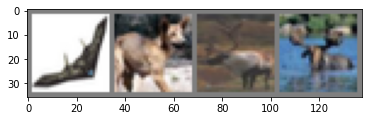

In [4]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

device = which_device()
model = Net(args).to(device)
show_model_summary(model, device, (3,32,32))


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

def test(model, device, test_loader, criterion, classes, test_losses, test_accs, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc > 85.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

def run():
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs, misclassified_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs

Let us show some of the training images, for fun.



In [5]:
# train and test the model
test_losses, test_accs, misclassified_imgs = run()



  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.0181326866149902 Batch_id=781 Accuracy=46.15: 100%|██████████| 782/782 [00:14<00:00, 54.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0190, Accuracy: 5646/10000 (56.46%)

EPOCH: 2


Loss=0.5192244052886963 Batch_id=781 Accuracy=61.37: 100%|██████████| 782/782 [00:14<00:00, 53.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0158, Accuracy: 6416/10000 (64.16%)

EPOCH: 3


Loss=1.1538536548614502 Batch_id=781 Accuracy=67.84: 100%|██████████| 782/782 [00:14<00:00, 53.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0130, Accuracy: 7042/10000 (70.42%)

EPOCH: 4


Loss=0.48697423934936523 Batch_id=781 Accuracy=71.55: 100%|██████████| 782/782 [00:14<00:00, 52.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0121, Accuracy: 7316/10000 (73.16%)

EPOCH: 5


Loss=0.5942544341087341 Batch_id=781 Accuracy=73.89: 100%|██████████| 782/782 [00:14<00:00, 53.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 7585/10000 (75.85%)

EPOCH: 6


Loss=1.3003109693527222 Batch_id=781 Accuracy=75.90: 100%|██████████| 782/782 [00:15<00:00, 51.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0105, Accuracy: 7652/10000 (76.52%)

EPOCH: 7


Loss=1.026038646697998 Batch_id=781 Accuracy=77.17: 100%|██████████| 782/782 [00:15<00:00, 50.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 7800/10000 (78.00%)

EPOCH: 8


Loss=0.8963719010353088 Batch_id=781 Accuracy=78.55: 100%|██████████| 782/782 [00:15<00:00, 52.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0097, Accuracy: 7821/10000 (78.21%)

EPOCH: 9


Loss=0.36128145456314087 Batch_id=781 Accuracy=79.34: 100%|██████████| 782/782 [00:14<00:00, 52.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0093, Accuracy: 7942/10000 (79.42%)

EPOCH: 10


Loss=0.53089439868927 Batch_id=781 Accuracy=80.12: 100%|██████████| 782/782 [00:14<00:00, 52.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 8071/10000 (80.71%)

EPOCH: 11


Loss=0.561331570148468 Batch_id=781 Accuracy=81.11: 100%|██████████| 782/782 [00:14<00:00, 52.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0088, Accuracy: 8071/10000 (80.71%)

EPOCH: 12


Loss=0.6216099262237549 Batch_id=781 Accuracy=81.97: 100%|██████████| 782/782 [00:15<00:00, 51.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8188/10000 (81.88%)

EPOCH: 13


Loss=0.8527905941009521 Batch_id=781 Accuracy=82.47: 100%|██████████| 782/782 [00:14<00:00, 52.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 8161/10000 (81.61%)

EPOCH: 14


Loss=0.2998955249786377 Batch_id=781 Accuracy=83.18: 100%|██████████| 782/782 [00:14<00:00, 52.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 8232/10000 (82.32%)

EPOCH: 15


Loss=0.7081393003463745 Batch_id=781 Accuracy=83.68: 100%|██████████| 782/782 [00:15<00:00, 52.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0079, Accuracy: 8299/10000 (82.99%)

EPOCH: 16


Loss=0.5210134387016296 Batch_id=781 Accuracy=84.08: 100%|██████████| 782/782 [00:15<00:00, 51.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8280/10000 (82.80%)

EPOCH: 17


Loss=1.1075997352600098 Batch_id=781 Accuracy=84.50: 100%|██████████| 782/782 [00:15<00:00, 51.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 8308/10000 (83.08%)

EPOCH: 18


Loss=0.2470163106918335 Batch_id=781 Accuracy=84.72: 100%|██████████| 782/782 [00:14<00:00, 52.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8346/10000 (83.46%)

EPOCH: 19


Loss=0.5226941108703613 Batch_id=781 Accuracy=85.41: 100%|██████████| 782/782 [00:14<00:00, 53.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 8262/10000 (82.62%)

EPOCH: 20


Loss=0.5794214010238647 Batch_id=781 Accuracy=85.78: 100%|██████████| 782/782 [00:14<00:00, 52.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8404/10000 (84.04%)

EPOCH: 21


Loss=0.7464200854301453 Batch_id=781 Accuracy=86.13: 100%|██████████| 782/782 [00:14<00:00, 52.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8343/10000 (83.43%)

EPOCH: 22


Loss=0.8506282567977905 Batch_id=781 Accuracy=86.52: 100%|██████████| 782/782 [00:14<00:00, 53.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8375/10000 (83.75%)

EPOCH: 23


Loss=0.4461202919483185 Batch_id=781 Accuracy=86.65: 100%|██████████| 782/782 [00:14<00:00, 53.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 8414/10000 (84.14%)

EPOCH: 24


Loss=1.357624888420105 Batch_id=781 Accuracy=87.08: 100%|██████████| 782/782 [00:15<00:00, 51.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 8377/10000 (83.77%)

EPOCH: 25


Loss=0.40379130840301514 Batch_id=781 Accuracy=87.34: 100%|██████████| 782/782 [00:15<00:00, 50.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8453/10000 (84.53%)

EPOCH: 26


Loss=0.452609121799469 Batch_id=781 Accuracy=87.74: 100%|██████████| 782/782 [00:15<00:00, 49.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8408/10000 (84.08%)

EPOCH: 27


Loss=0.4623816907405853 Batch_id=781 Accuracy=87.69: 100%|██████████| 782/782 [00:15<00:00, 50.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8445/10000 (84.45%)

EPOCH: 28


Loss=0.3077651560306549 Batch_id=781 Accuracy=87.99: 100%|██████████| 782/782 [00:15<00:00, 51.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8470/10000 (84.70%)

EPOCH: 29


Loss=0.659542441368103 Batch_id=781 Accuracy=88.31: 100%|██████████| 782/782 [00:15<00:00, 50.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 91 %
Accuracy of  bird : 81 %
Accuracy of   cat : 75 %
Accuracy of  deer : 86 %
Accuracy of   dog : 94 %
Accuracy of  frog : 79 %
Accuracy of horse : 86 %
Accuracy of  ship : 87 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0070, Accuracy: 8502/10000 (85.02%)

EPOCH: 30


Loss=0.08287149667739868 Batch_id=781 Accuracy=88.60: 100%|██████████| 782/782 [00:15<00:00, 49.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8446/10000 (84.46%)

EPOCH: 31


Loss=0.1557515412569046 Batch_id=781 Accuracy=88.94: 100%|██████████| 782/782 [00:15<00:00, 50.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0071, Accuracy: 8481/10000 (84.81%)

EPOCH: 32


Loss=0.06390772759914398 Batch_id=781 Accuracy=88.90: 100%|██████████| 782/782 [00:15<00:00, 50.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 8494/10000 (84.94%)

EPOCH: 33


Loss=0.11654606461524963 Batch_id=781 Accuracy=89.07: 100%|██████████| 782/782 [00:15<00:00, 50.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8437/10000 (84.37%)

EPOCH: 34


Loss=0.14979828894138336 Batch_id=781 Accuracy=89.37: 100%|██████████| 782/782 [00:15<00:00, 50.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 87 %
Accuracy of  bird : 77 %
Accuracy of   cat : 76 %
Accuracy of  deer : 78 %
Accuracy of   dog : 79 %
Accuracy of  frog : 83 %
Accuracy of horse : 78 %
Accuracy of  ship : 92 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0070, Accuracy: 8505/10000 (85.05%)

EPOCH: 35


Loss=0.5242259502410889 Batch_id=781 Accuracy=89.31: 100%|██████████| 782/782 [00:15<00:00, 49.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8455/10000 (84.55%)

EPOCH: 36


Loss=0.8721731901168823 Batch_id=781 Accuracy=89.54: 100%|██████████| 782/782 [00:15<00:00, 51.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 92 %
Accuracy of  bird : 73 %
Accuracy of   cat : 74 %
Accuracy of  deer : 87 %
Accuracy of   dog : 70 %
Accuracy of  frog : 82 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0069, Accuracy: 8547/10000 (85.47%)

EPOCH: 37


Loss=0.20863592624664307 Batch_id=781 Accuracy=89.84: 100%|██████████| 782/782 [00:15<00:00, 49.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 95 %
Accuracy of  bird : 79 %
Accuracy of   cat : 65 %
Accuracy of  deer : 86 %
Accuracy of   dog : 76 %
Accuracy of  frog : 85 %
Accuracy of horse : 89 %
Accuracy of  ship : 90 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0070, Accuracy: 8504/10000 (85.04%)

EPOCH: 38


Loss=0.17039690911769867 Batch_id=781 Accuracy=90.00: 100%|██████████| 782/782 [00:15<00:00, 50.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 8494/10000 (84.94%)

EPOCH: 39


Loss=0.2812581956386566 Batch_id=781 Accuracy=89.83: 100%|██████████| 782/782 [00:15<00:00, 49.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 91 %
Accuracy of  bird : 77 %
Accuracy of   cat : 77 %
Accuracy of  deer : 86 %
Accuracy of   dog : 80 %
Accuracy of  frog : 95 %
Accuracy of horse : 96 %
Accuracy of  ship : 89 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0069, Accuracy: 8533/10000 (85.33%)

EPOCH: 40


Loss=0.5332460403442383 Batch_id=781 Accuracy=90.24: 100%|██████████| 782/782 [00:15<00:00, 50.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 86 %
Accuracy of   car : 98 %
Accuracy of  bird : 73 %
Accuracy of   cat : 62 %
Accuracy of  deer : 81 %
Accuracy of   dog : 70 %
Accuracy of  frog : 84 %
Accuracy of horse : 82 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0070, Accuracy: 8522/10000 (85.22%)

EPOCH: 41


Loss=0.5412896871566772 Batch_id=781 Accuracy=90.37: 100%|██████████| 782/782 [00:15<00:00, 49.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 72 %
Accuracy of   cat : 69 %
Accuracy of  deer : 84 %
Accuracy of   dog : 80 %
Accuracy of  frog : 95 %
Accuracy of horse : 82 %
Accuracy of  ship : 96 %
Accuracy of truck : 83 %

Test set: Average loss: 0.0070, Accuracy: 8560/10000 (85.60%)

EPOCH: 42


Loss=1.0722250938415527 Batch_id=781 Accuracy=90.66: 100%|██████████| 782/782 [00:15<00:00, 49.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 8453/10000 (84.53%)

EPOCH: 43


Loss=0.45194894075393677 Batch_id=781 Accuracy=90.59: 100%|██████████| 782/782 [00:15<00:00, 49.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 86 %
Accuracy of   car : 91 %
Accuracy of  bird : 87 %
Accuracy of   cat : 69 %
Accuracy of  deer : 81 %
Accuracy of   dog : 72 %
Accuracy of  frog : 90 %
Accuracy of horse : 90 %
Accuracy of  ship : 88 %
Accuracy of truck : 80 %

Test set: Average loss: 0.0070, Accuracy: 8522/10000 (85.22%)

EPOCH: 44


Loss=0.706997275352478 Batch_id=781 Accuracy=90.71: 100%|██████████| 782/782 [00:15<00:00, 50.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 8491/10000 (84.91%)

EPOCH: 45


Loss=0.3948194980621338 Batch_id=781 Accuracy=90.64: 100%|██████████| 782/782 [00:15<00:00, 50.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 91 %
Accuracy of  bird : 80 %
Accuracy of   cat : 71 %
Accuracy of  deer : 87 %
Accuracy of   dog : 75 %
Accuracy of  frog : 94 %
Accuracy of horse : 86 %
Accuracy of  ship : 95 %
Accuracy of truck : 82 %

Test set: Average loss: 0.0069, Accuracy: 8524/10000 (85.24%)

EPOCH: 46


Loss=0.348957359790802 Batch_id=781 Accuracy=90.88: 100%|██████████| 782/782 [00:15<00:00, 49.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0073, Accuracy: 8468/10000 (84.68%)

EPOCH: 47


Loss=0.45883089303970337 Batch_id=781 Accuracy=91.13: 100%|██████████| 782/782 [00:15<00:00, 50.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 90 %
Accuracy of  bird : 76 %
Accuracy of   cat : 73 %
Accuracy of  deer : 88 %
Accuracy of   dog : 87 %
Accuracy of  frog : 87 %
Accuracy of horse : 84 %
Accuracy of  ship : 88 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0070, Accuracy: 8570/10000 (85.70%)

EPOCH: 48


Loss=0.09061938524246216 Batch_id=781 Accuracy=91.05: 100%|██████████| 782/782 [00:15<00:00, 49.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 98 %
Accuracy of  bird : 77 %
Accuracy of   cat : 61 %
Accuracy of  deer : 81 %
Accuracy of   dog : 75 %
Accuracy of  frog : 85 %
Accuracy of horse : 85 %
Accuracy of  ship : 90 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0070, Accuracy: 8549/10000 (85.49%)

EPOCH: 49


Loss=0.6426309943199158 Batch_id=781 Accuracy=91.24: 100%|██████████| 782/782 [00:15<00:00, 50.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 98 %
Accuracy of  bird : 84 %
Accuracy of   cat : 77 %
Accuracy of  deer : 79 %
Accuracy of   dog : 74 %
Accuracy of  frog : 87 %
Accuracy of horse : 85 %
Accuracy of  ship : 95 %
Accuracy of truck : 82 %

Test set: Average loss: 0.0069, Accuracy: 8541/10000 (85.41%)

EPOCH: 50


Loss=0.376706063747406 Batch_id=781 Accuracy=91.43: 100%|██████████| 782/782 [00:15<00:00, 50.55it/s]



Accuracy of plane : 87 %
Accuracy of   car : 96 %
Accuracy of  bird : 76 %
Accuracy of   cat : 79 %
Accuracy of  deer : 84 %
Accuracy of   dog : 88 %
Accuracy of  frog : 87 %
Accuracy of horse : 88 %
Accuracy of  ship : 92 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0069, Accuracy: 8528/10000 (85.28%)



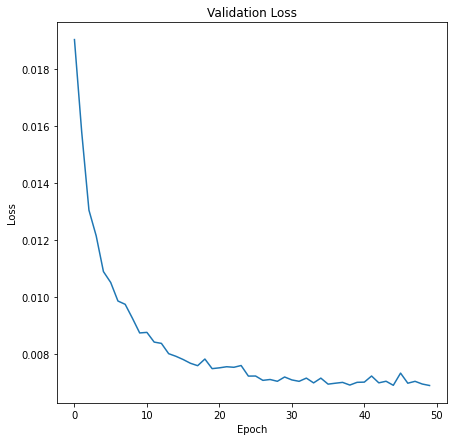

In [6]:
plot_graph(test_losses, "Loss")



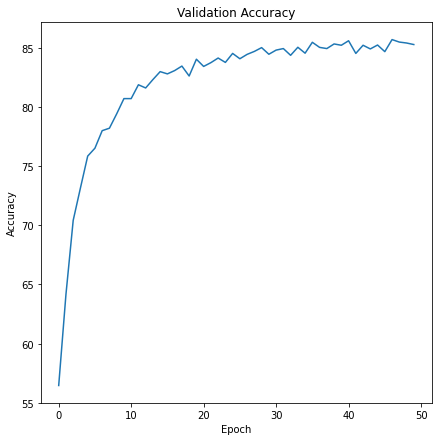

In [7]:
plot_graph(test_accs, "Accuracy")



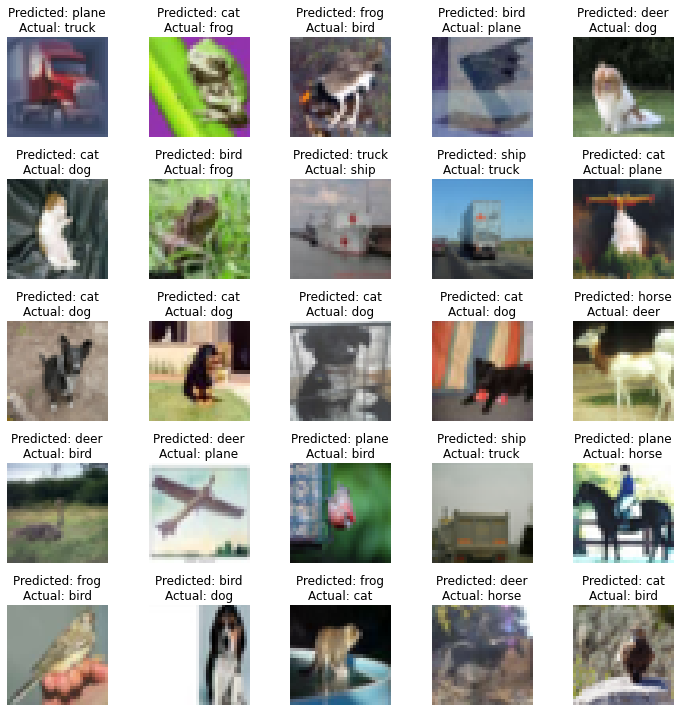

In [8]:
plot_misclassified_images(misclassified_imgs, data.classes, "misclassified_imgs.png")